# Tuning experiments for the Movielens dataset

Feel free to re-run this and change hyperparameters as you see fit.

This notebook should also be a good place to load the data only once and then train multiple times, generate charts, etc.


In [1]:
from data_loader import load_data, train_test_split, MovielensDataset
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
import argparse
import yaml
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error

from gmf import GMF
from ncf_mlp import NCF_MLP
from neural_mf import NEURAL_MF

from train import train_gmf, train_joint_nerual_mf, train_mlp, train_neural_mf, train_loop, test_loop

from matplotlib import pyplot as plt

In [2]:
# Starting hyperparameters
learning_rate = 0.05
weight_decay = 0.0000001
epochs = 5
batch_size = 1024
latent_dims = 16
alpha: 0.5
loss = nn.MSELoss()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the data
dataset = '100k'
data, num_users, num_items = load_data(dataset, rescale_data=True)
print(data.head())
train, test = train_test_split(data)

   user_id  movie_id  rating  timestamp
0        0         0     0.6  881250949
1        1         1     0.6  891717742
2        2         2     0.2  878887116
3        3         3     0.4  880606923
4        4         4     0.2  886397596


In [5]:
train = MovielensDataset(users=train['user_id'], movies=train['movie_id'], ratings = train['rating'])
test = MovielensDataset(users=test['user_id'], movies=test['movie_id'], ratings = test['rating'])

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers= 4)

## Tune Hyperparameters for Models

In [6]:
def tune_lr(model_type='gmf'):
    """Tune Learning Rate for a model type"""
    learning_rates = np.array([0.001, 0.01, 0.05, 0.07, 0.1, 0.2])
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_lr = 0.01
    best_RMSE = np.inf
    for lr in learning_rates:
        if model_type == 'gmf':
            print('TRAINING GMF')
            train_model = train_gmf
        elif model_type == 'mlp':
            print('TRAINING MLP')
            train_model = train_mlp
        else:
            print('TRAINING NMF')
            train_model = train_nmf
        model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs, latent_dims,
                            lr, # Param being tuned
                            'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_lr = lr
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    print()
    print('Finished tuning model', model_type)
    print('Best Learning Rate:', best_lr)
    print('Best Train RMSE:', best_RMSE)
    print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_lr, best_model, learning_rates, curve_data)


In [7]:
def tune_dims(model_type='gmf'):
    """Tune Embedding Dimensions for a model type"""
    dims = [8, 16, 32, 64, 128, 256]
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_dim = 0.01
    best_RMSE = np.inf
    for dim in dims:
        if model_type == 'gmf':
            print('TRAINING GMF')
            train_model = train_gmf
        elif model_type == 'mlp':
            print('TRAINING MLP')
            train_model = train_mlp
        else:
            print('TRAINING NMF')
            train_model = train_nmf
        model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs,
                            dim, # Param being tuned 
                            learning_rate, 'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_dim = dim
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    print()
    print('Finished tuning model', model_type)
    print('Best Embedding Dim:', best_dim)
    print('Best Train RMSE:', best_RMSE)
    print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_dim, best_model, dims, curve_data)


In [8]:
gmf_lr, gmf_model, gmf_lr_history, gmf_lr_curves = tune_lr('gmf')

TRAINING GMF
Epoch 1
------------------------
loss: 1.150281  [ 1024/79619]
Test MSE 18.33479766242037
Test RMSE 4.281915186271252
Epoch 2
------------------------
loss: 0.753372  [ 1024/79619]
Test MSE 13.426858901842111
Test RMSE 3.6642678534520523
Epoch 3
------------------------
loss: 0.540316  [ 1024/79619]
Test MSE 10.441810042602956
Test RMSE 3.231378969202306
Epoch 4
------------------------
loss: 0.420905  [ 1024/79619]
Test MSE 8.362241341650844
Test RMSE 2.891754025094604
Epoch 5
------------------------
loss: 0.319412  [ 1024/79619]
Test MSE 6.769831899626859
Test RMSE 2.601890062940181
Test MSE 6.750077710827357
Test RMSE 2.5980911667659696
Test MSE 6.769831899626859
Test RMSE 2.601890062940181
TRAINING GMF
Epoch 1
------------------------
loss: 1.089576  [ 1024/79619]
Test MSE 2.5461783601266688
Test RMSE 1.5956748917391252
Epoch 2
------------------------
loss: 0.097367  [ 1024/79619]
Test MSE 1.3022314835008868
Test RMSE 1.1411535757736058
Epoch 3
----------------------

In [9]:
def plot_learning_curve(param_history, curves, title='Training Curve'):
    """Plot learning curves for a given model's tuning history

    curves -- a dictionary from a curve label to its historical data. The length of the curve history should be equal
              to the length of param_history
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    curve_labels = curves.keys()
    for curve_label in curve_labels:
        curve_data = curves[curve_label]
        ax.plot(param_history, curve_data, label=curve_label)

    fig.suptitle(title)
    fig.legend()
    fig.show()
    

/tmp/ipykernel_774363/1503343490.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


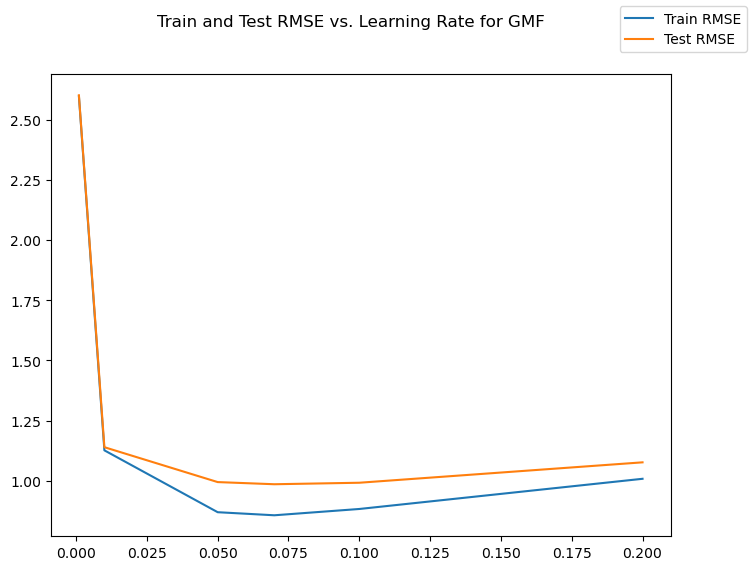

In [10]:
plot_learning_curve(gmf_lr_history, gmf_lr_curves, "Train and Test RMSE vs. Learning Rate for GMF")

In [11]:
gmf_dim, gmf_model, gmf_dim_history, gmf_dim_curves = tune_dims('gmf')

TRAINING GMF
Epoch 1
------------------------
loss: 0.749833  [ 1024/79619]
Test MSE 1.2904081665150569
Test RMSE 1.1359613402378872
Epoch 2
------------------------
loss: 0.050885  [ 1024/79619]
Test MSE 1.2988819105743252
Test RMSE 1.13968500497915
Epoch 3
------------------------
loss: 0.053797  [ 1024/79619]
Test MSE 1.2922716434453623
Test RMSE 1.1367812645559225
Epoch 4
------------------------
loss: 0.049483  [ 1024/79619]
Test MSE 1.099671254458107
Test RMSE 1.0486521131710493
Epoch 5
------------------------
loss: 0.036903  [ 1024/79619]
Test MSE 1.024760294420902
Test RMSE 1.0123044474963556
Test MSE 0.8715037037258652
Test RMSE 0.933543627114376
Test MSE 1.0247602944209018
Test RMSE 1.0123044474963556
TRAINING GMF
Epoch 1
------------------------
loss: 0.721279  [ 1024/79619]
Test MSE 1.304504113478945
Test RMSE 1.1421489016231399
Epoch 2
------------------------
loss: 0.049521  [ 1024/79619]
Test MSE 1.306774780332895
Test RMSE 1.1431425021986084
Epoch 3
-------------------

/tmp/ipykernel_774363/1503343490.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


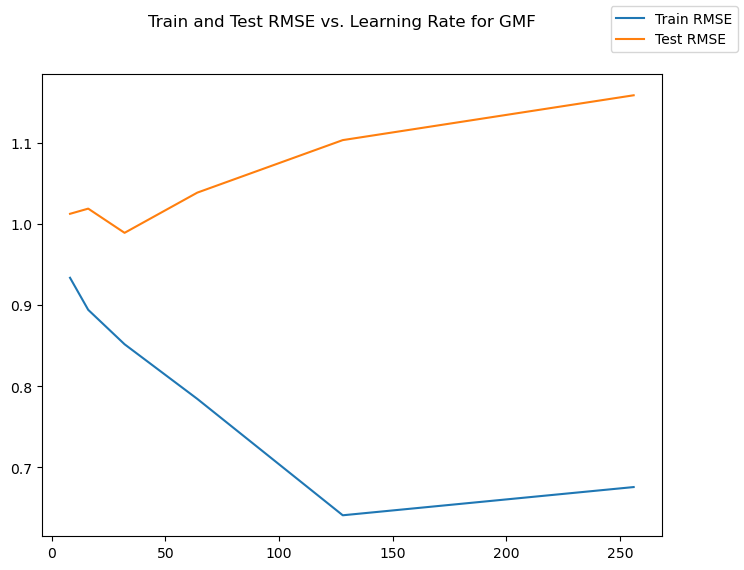

In [12]:
plot_learning_curve(gmf_dim_history, gmf_dim_curves, "Train and Test RMSE vs. Learning Rate for GMF")

# Evaluation of Models

In [6]:
from eval import hit_rate
from train import train_gmf, train_mlp, train_neural_mf

In [7]:
# Train a basic model for evaluation, feel free to use some other pretrained model.
learning_rate = 0.01
weight_decay = 0.0000001
epochs = 2
batch_size = 1024
latent_dims = 256
alpha: 0.5
loss = nn.MSELoss()

model = train_mlp(train_dataloader,
                  test_dataloader,
                  num_users,
                  num_items,
                  epochs,
                  latent_dims,
                  learning_rate,
                  'adam',
                  criterion=loss,
                  device=device,
                  weight_decay=weight_decay,
                  rescale_data=True)


Epoch 1
-------------------------------
loss: 0.241222  [ 1024/79619]
Test MSE 0.9350126160995116
Test RMSE 0.966960503898433
Epoch 2
-------------------------------
loss: 0.033831  [ 1024/79619]
Test MSE 0.9176657476848611
Test RMSE 0.957948718713513


In [10]:
# Calculate the hit rate, only considering the first 100 users and movies
hr, users_to_ratings = hit_rate(model, 10, num_users, num_items, data, device, 10000)

NameError: name 'num_movies' is not defined

In [9]:
hr, users_to_ratings

(0.64,
 {0: [(array([0.63018954], dtype=float32), 19),
   (array([0.61617815], dtype=float32), 85),
   (array([0.61570835], dtype=float32), 61),
   (array([0.6136162], dtype=float32), 27),
   (array([0.60114086], dtype=float32), 55),
   (array([0.59069246], dtype=float32), 74),
   (array([0.57889473], dtype=float32), 14),
   (array([0.5607247], dtype=float32), 69),
   (array([0.4778402], dtype=float32), 42),
   (array([0.46799362], dtype=float32), 2)],
  1: [(array([0.64158726], dtype=float32), 61),
   (array([0.6346004], dtype=float32), 51),
   (array([0.63149583], dtype=float32), 55),
   (array([0.6238011], dtype=float32), 85),
   (array([0.61909664], dtype=float32), 74),
   (array([0.6160263], dtype=float32), 25),
   (array([0.59477097], dtype=float32), 14),
   (array([0.5629916], dtype=float32), 69),
   (array([0.4989131], dtype=float32), 42),
   (array([0.47783983], dtype=float32), 2)],
  2: [(array([0.60769033], dtype=float32), 35),
   (array([0.60329723], dtype=float32), 95),
  